# **Face Morphing**

---

### Face morphing is a technique that involves blending two or more images of faces together in order to create a new image that appears to be a hybrid of the original faces. [Code Source](https://github.com/Azmarie/Face-Morphing/)



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
folder_dir = "/content/gdrive/MyDrive/Computer Vision/Face Morphing/"

Mounted at /content/gdrive


In [ ]:
# Import Dependancies
import glob
import os
from os import listdir
import sys
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import imutils 
from imutils import face_utils
import dlib
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import random
import math

### **Loading Images:** The first step in face morphing is to load the images that we want to blend together. These images should be of the same size and orientation, size is covered by the crop functions but orientation isn't, if you need to align your images you should use an aligning script such as [this one.](https://github.com/Azmarie/Face-Morphing/tree/master/code/utils)

In [ ]:
# Import Images
images = [cv2.imread(item) for i in [glob.glob(f'{folder_dir}*.png')] for item in i]

In [ ]:
# Image Names as Labels
image_names = [image for image in os.listdir(folder_dir) if image.endswith('.png')]

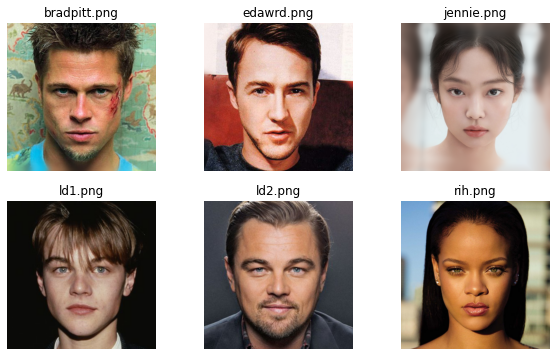

In [ ]:
# Display Loaded Images
rows = 2
columns = 3
fig = plt.figure(figsize=(10, 6))
for i, image in enumerate(images):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(imutils.opencv2matplotlib(image))
  plt.axis('off')
  plt.title(image_names[i])

In [ ]:
# Cropping Images
class NoFaceFound(Exception):
   """Raised when there is no face found"""
   pass

# Calculate Image Dimensions
def calculate_margin_help(img1,img2):
    """ 
    Returns dimensions, difference in dimensions and average dimensions of two images.
    """
    # Dimensions of first image
    size1 = img1.shape
    # Dimensions of second image
    size2 = img2.shape
    # Difference in width between images
    diff0 = abs(size1[0]-size2[0])//2
    # Difference in height between images
    diff1 = abs(size1[1]-size2[1])//2
    # Average of width between images
    avg0 = (size1[0]+size2[0])//2
    # Average of height between images
    avg1 = (size1[1]+size2[1])//2

    return [size1,size2,diff0,diff1,avg0,avg1]

# Crop Image
def crop_image(img1,img2):
    # Get image info using margin help function
    [size1,size2,diff0,diff1,avg0,avg1] = calculate_margin_help(img1,img2)

    # Do nothing in case the dimensions of the image match
    if(size1[0] == size2[0] and size1[1] == size2[1]):
        return [img1,img2]

    # Resize second image in case it's bigger than the first image
    elif(size1[0] <= size2[0] and size1[1] <= size2[1]):
        scale0 = size1[0]/size2[0]
        scale1 = size1[1]/size2[1]
        if(scale0 > scale1):
            res = cv2.resize(img2,None,fx=scale0,fy=scale0,interpolation=cv2.INTER_AREA)
        else:
            res = cv2.resize(img2,None,fx=scale1,fy=scale1,interpolation=cv2.INTER_AREA)
        return crop_image_help(img1,res)
    
    # Resize first image in case it's bigger than the second image
    elif(size1[0] >= size2[0] and size1[1] >= size2[1]):
        scale0 = size2[0]/size1[0]
        scale1 = size2[1]/size1[1]
        if(scale0 > scale1):
            res = cv2.resize(img1,None,fx=scale0,fy=scale0,interpolation=cv2.INTER_AREA)
        else:
            res = cv2.resize(img1,None,fx=scale1,fy=scale1,interpolation=cv2.INTER_AREA)
        return crop_image_help(res,img2)

    # In case of a shape mismatch, resize both images to the average of their dimensions
    elif(size1[0] >= size2[0] and size1[1] <= size2[1]):
        return [img1[diff0:avg0,:],img2[:,-diff1:avg1]]
    else:
        return [img1[:,diff1:avg1],img2[-diff0:avg0,:]]

# Crop Image Helper Function
def crop_image_help(img1,img2):
    # Get image info using margin help function
    [size1,size2,diff0,diff1,avg0,avg1] = calculate_margin_help(img1,img2)
    
    # If the dimensions match, do nothing
    if(size1[0] == size2[0] and size1[1] == size2[1]):
        return [img1,img2]

    # If the dimensions don't match, crop as necessary
    elif(size1[0] <= size2[0] and size1[1] <= size2[1]):
        return [img1,img2[-diff0:avg0,-diff1:avg1]]

    elif(size1[0] >= size2[0] and size1[1] >= size2[1]):
        return [img1[diff0:avg0,diff1:avg1],img2]

    elif(size1[0] >= size2[0] and size1[1] <= size2[1]):
        return [img1[diff0:avg0,:],img2[:,-diff1:avg1]]

    else:
        return [img1[:,diff1:avg1],img2[diff0:avg0,:]]

### **Locate Facial Landmarks:** Next, we need to locate the facial landmarks in each image. This can be done using various methods such as using a pre-trained facial landmark detector or training a custom landmark detector. The landmark points should be consistent across all images, as they will be used to define the correspondences between the images. For this task dlib was used with a [pre-trained model](https://github.com/davisking/dlib-models) loaded. The model is also available on my Google Drive linked at the end of the notebook.

In [ ]:
# Locate Facial Landmarks
def generate_face_correspondences(theImage1, theImage2):
    # Detect the points of face.
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('/content/gdrive/MyDrive/Computer Vision/Face Morphing/shape_predictor_68_face_landmarks.dat')
    corresp = np.zeros((68,2))
    
    imgList = crop_image(theImage1,theImage2)
    list1 = []
    list2 = []
    j = 1

    for img in imgList:

        size = (img.shape[0],img.shape[1])
        if(j == 1):
            currList = list1
        else:
            currList = list2

        # Ask the detector to find the bounding boxes of each face. The 1 in the
        # second argument indicates that we should upsample the image 1 time. This
        # will make everything bigger and allow us to detect more faces.

        dets = detector(img, 1)

        try:
            if len(dets) == 0:
                raise NoFaceFound
        except NoFaceFound:
            print("Sorry, but I couldn't find a face in the image.")

        j=j+1

        for k, rect in enumerate(dets):
            
            # Get the landmarks/parts for the face in rect.
            shape = predictor(img, rect)
            # corresp = face_utils.shape_to_np(shape)
            
            for i in range(0,68):
                x = shape.part(i).x
                y = shape.part(i).y
                currList.append((x, y))
                corresp[i][0] += x
                corresp[i][1] += y
                # cv2.circle(img, (x, y), 2, (0, 255, 0), 2)

            # Add back the background
            currList.append((1,1))
            currList.append((size[1]-1,1))
            currList.append(((size[1]-1)//2,1))
            currList.append((1,size[0]-1))
            currList.append((1,(size[0]-1)//2))
            currList.append(((size[1]-1)//2,size[0]-1))
            currList.append((size[1]-1,size[0]-1))
            currList.append(((size[1]-1),(size[0]-1)//2))

    # Add back the background
    narray = corresp/2
    narray = np.append(narray,[[1,1]],axis=0)
    narray = np.append(narray,[[size[1]-1,1]],axis=0)
    narray = np.append(narray,[[(size[1]-1)//2,1]],axis=0)
    narray = np.append(narray,[[1,size[0]-1]],axis=0)
    narray = np.append(narray,[[1,(size[0]-1)//2]],axis=0)
    narray = np.append(narray,[[(size[1]-1)//2,size[0]-1]],axis=0)
    narray = np.append(narray,[[size[1]-1,size[0]-1]],axis=0)
    narray = np.append(narray,[[(size[1]-1),(size[0]-1)//2]],axis=0)
    
    return [size,imgList[0],imgList[1],list1,list2,narray]

### **Create a Triangulation:** The next step is to create a triangulation of the facial landmarks. A Delaunay triangulation is typically used, which involves creating a mesh of triangles that covers the entire face. The triangulation will be used to warp and blend the images together.

In [ ]:
# Check if a point is inside a rectangle
def rect_contains(rect, point):

    if point[0] < rect[0]:
        return False
    elif point[1] < rect[1]:
        return False
    elif point[0] > rect[2]:
        return False
    elif point[1] > rect[3]:
        return False
    return True

# Write the delaunay triangles into a file
def draw_delaunay(f_w, f_h, subdiv, dictionary1):

    list4 = []

    triangleList = subdiv.getTriangleList()
    r = (0, 0, f_w, f_h)

    for t in triangleList :
        pt1 = (int(t[0]), int(t[1]))
        pt2 = (int(t[2]), int(t[3]))
        pt3 = (int(t[4]), int(t[5]))

        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
            list4.append((dictionary1[pt1],dictionary1[pt2],dictionary1[pt3]))

    dictionary1 = {}
    return list4

# Triangulate
def make_delaunay(f_w, f_h, theList, img1, img2):

    # Make a rectangle.
    rect = (0, 0, f_w, f_h)

    # Create an instance of Subdiv2D.
    subdiv = cv2.Subdiv2D(rect)

    # Make a points list and a searchable dictionary. 
    theList = theList.tolist()
    points = [(int(x[0]),int(x[1])) for x in theList]
    dictionary = {x[0]:x[1] for x in list(zip(points, range(76)))}
    
    # Insert points into subdiv
    for p in points :
        subdiv.insert(p)

    # Make a delaunay triangulation list.
    list4 = draw_delaunay(f_w, f_h, subdiv, dictionary)
   
    # Return the list.
    return list4

### **Calculate the Affine Transformations:** Using the triangulation, we can calculate the affine transformations that will be used to warp the images. Each triangle in one image will be warped to the corresponding triangle in the other image. The affine transformations can be calculated using the set of corresponding points in each triangle. 

### **Warp the Images:** Once the affine transformations have been calculated, we can warp each triangle in one image to its corresponding triangle in the other image. This involves applying the affine transformation to each pixel in the triangle to find its corresponding location in the other image. The pixels are then blended together using a weighted average based on the distance between the pixels and the vertices of the triangles.

In [ ]:
# Apply affine transform calculated using srcTri and dstTri to src and output an image of size.
def apply_affine_transform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine(src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    return dst

# Warps and alpha blends triangular regions from img1 and img2 to img
def morph_triangle(img1, img2, img, t1, t2, t, alpha) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    r = cv2.boundingRect(np.float32([t]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = []
    t2Rect = []
    tRect = []

    for i in range(0, 3):
        tRect.append(((t[i][0] - r[0]),(t[i][1] - r[1])))
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))

    # Get mask by filling triangle
    mask = np.zeros((r[3], r[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(tRect), (1.0, 1.0, 1.0), 16, 0)

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2Rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

    size = (r[2], r[3])
    warpImage1 = apply_affine_transform(img1Rect, t1Rect, tRect, size)
    warpImage2 = apply_affine_transform(img2Rect, t2Rect, tRect, size)

    # Alpha blend rectangular patches
    imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2

    # Copy triangular region of the rectangular patch to the output image
    img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * ( 1 - mask ) + imgRect * mask


### **Create the Morph Sequence:** Finally, we can create the morph sequence by interpolating between the two warped images. This involves blending the two images together using a set of weights that range from 0 to 1. At each weight value, we calculate a weighted average of the two warped images, creating a series of intermediate images that blend the two original images together.

In [ ]:
def generate_morph_sequence(duration,frame_rate,img1,img2,points1,points2,tri_list,size,output):

    num_images = int(duration*frame_rate)
    gif = [] # Stores Morphed Frames
  
    for j in range(0, num_images):

        # Convert Mat to float data type
        img1 = np.float32(img1)
        img2 = np.float32(img2)

        # Read array of corresponding points
        points = []
        alpha = j/(num_images-1)

        # Compute weighted average point coordinates
        for i in range(0, len(points1)):
            x = (1 - alpha) * points1[i][0] + alpha * points2[i][0]
            y = (1 - alpha) * points1[i][1] + alpha * points2[i][1]
            points.append((x,y))
        
        # Allocate space for final output
        morphed_frame = np.zeros(img1.shape, dtype = img1.dtype)

        for i in range(len(tri_list)):    
            x = int(tri_list[i][0])
            y = int(tri_list[i][1])
            z = int(tri_list[i][2])
            
            t1 = [points1[x], points1[y], points1[z]]
            t2 = [points2[x], points2[y], points2[z]]
            t = [points[x], points[y], points[z]]

            # Morph one triangle at a time.
            morph_triangle(img1, img2, morphed_frame, t1, t2, t, alpha)
            
            pt1 = (int(t[0][0]), int(t[0][1]))
            pt2 = (int(t[1][0]), int(t[1][1]))
            pt3 = (int(t[2][0]), int(t[2][1]))

            cv2.line(morphed_frame, pt1, pt2, (255, 255, 255), 1, 8, 0)
            cv2.line(morphed_frame, pt2, pt3, (255, 255, 255), 1, 8, 0)
            cv2.line(morphed_frame, pt3, pt1, (255, 255, 255), 1, 8, 0)
            
        res = Image.fromarray(cv2.cvtColor(np.uint8(morphed_frame), cv2.COLOR_BGR2RGB))
        gif.append(res)
        

    # Save output to GIF
    gif[0].save(f'{output}.gif', save_all=True,optimize=False, append_images=gif[1:], loop=0)
    
    # Plots thumbnails of morphed frames
    fig, axs = plt.subplots(10, 10)
    for i, ax in enumerate(axs.flat):
      ax.imshow(gif[i])
      ax.axis('off')

In [ ]:
# Define Wrapper Function
def doMorphing(img1, img2, duration, frame_rate, output):
	[size, img1, img2, points1, points2, list3] = generate_face_correspondences(img1, img2)
	tri = make_delaunay(size[1], size[0], list3, img1, img2)
	generate_morph_sequence(duration, frame_rate, img1, img2, points1, points2, tri, size,output)

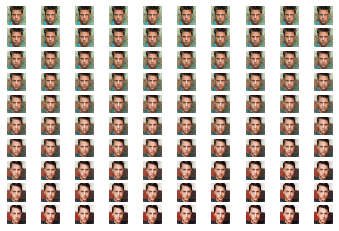

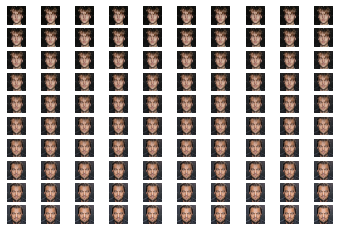

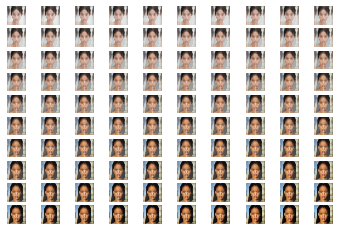

In [ ]:
# Calling this function will output a GIF as well as an inline plot that has thumbnails from the morphed frames
doMorphing(images[0],images[1],5,20,'bradnorton')
doMorphing(images[3],images[4],5,20,'leoages')
doMorphing(images[2],images[5],5,20,'rihjenine')

The GIFs that show the morphing sequence are saved on [Google Drive](https://drive.google.com/drive/folders/1n7iRsWiVVOQiN9m8oxz8yjI2mHFY4ZeC?usp=share_link) for convenience.